# Import Libraries

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from ml.utils.utils import adfuller_test, get_data, kpss_test, prepare_monthly_healthcare_series

%matplotlib inline

In [6]:
## Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 

## Ignore warnings
warnings.filterwarnings("ignore")

# Read the Data

In [2]:
df = get_data("CallCenterData", "raw")
df.head()

,month,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
0,31-Jan,631,8,6,2,19,1,4
1,28-Feb,633,9,7,3,27,1,3
2,31-Mar,766,4,4,2,24,1,1
3,30-Apr,768,12,6,3,32,1,1
4,31-May,1003,2,7,2,42,1,4


In [7]:
df.tail()

,month,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
127,31-Aug,20257,4486,1111,212,371,4,3
128,30-Sep,19207,4474,1020,135,362,3,1
129,31-Oct,23414,5138,1310,188,523,3,4
130,30-Nov,23602,4883,1297,199,479,7,1
131,31-Dec,20058,4150,1118,159,349,4,2


In [8]:
df.shape

(132, 8)

## About the dataset

- Dataset spans 11 years of monthly data. 

In [9]:
# check for missing values in the data

df.isnull().sum()

month            0
Healthcare       0
Telecom          0
Banking          0
Technology       0
Insurance        0
#ofphonelines    0
#noofchannels    0
dtype: int64

# Setting date as Index

In [18]:
# Describe the datetime field "month"
df.month.describe()

count        132
unique        13
top       31-Jan
freq          11
Name: month, dtype: object

In [3]:
start_year = 2014 

In [4]:
analysis_df = prepare_monthly_healthcare_series(df, start_year)

E:\Learnings\Learning_curves\Call_Center_Traffic_Forecasting\ml\utils\utils.py:589: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .assign(index=pd.date_range(start=f"{start_year}-01", periods=len(df), freq='M'))
E:\Learnings\Learning_curves\Call_Center_Traffic_Forecasting\ml\utils\utils.py:591: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .asfreq('M')


In [5]:
analysis_df.head()

index
2014-01-31     631
2014-02-28     633
2014-03-31     766
2014-04-30     768
2014-05-31    1003
Freq: ME, Name: Healthcare, dtype: int64

# Descriptive Stats

In [25]:
analysis_df.describe()

count      132.000000
mean      9856.704545
std       6221.071304
min        631.000000
25%       3744.250000
50%       9651.500000
75%      15590.750000
max      23602.000000
Name: Healthcare, dtype: float64

# Time Series Visualization

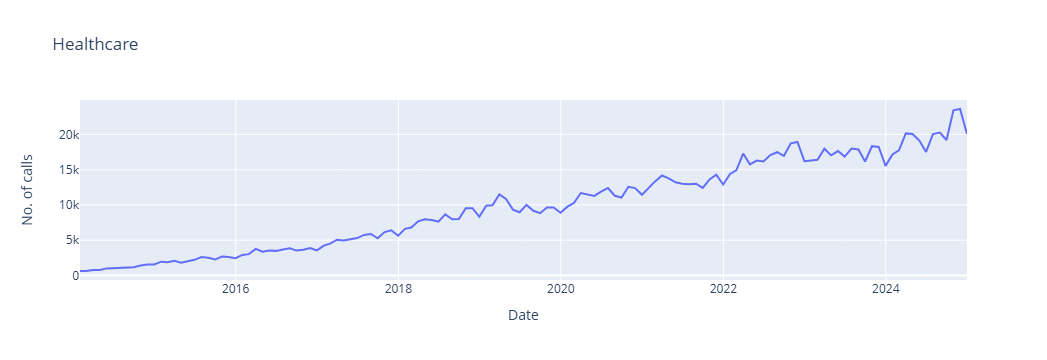

In [28]:
fig = px.line(analysis_df, x=analysis_df.index, y=analysis_df.values, title="Healthcare")
fig.update_layout(xaxis_title="Date", yaxis_title="No. of calls")
fig.show()

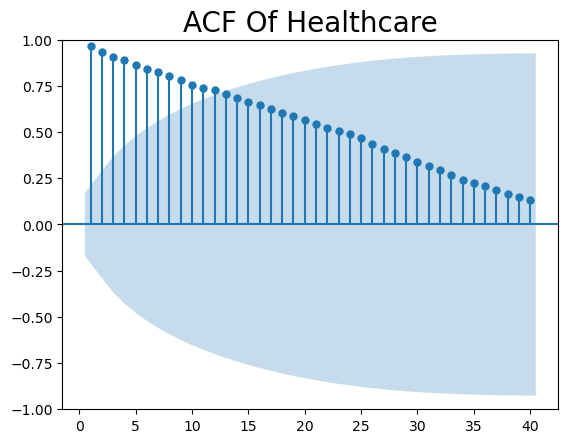

In [29]:
# Plot the autocorrelation function (ACF) of the "Healthcare" column
sgt.plot_acf(analysis_df.values, zero=False, lags=40)
plt.title("ACF Of Healthcare", size=20)
plt.show()

## Observations

- There is upward rising trend.
- Seasonality is observed specially there is peak in month of March.
- From 2022 there is peak in month of October.
-  While the overall level of the series increases significantly, the magnitude of the seasonal fluctuations appears to remain relatively consistent.the seasonality in the "Healthcare" data appears to be additive.

# Stationarity

In [30]:
adf_result = adfuller_test(analysis_df)
print("ADF Test Result:", adf_result)

kpss_result = kpss_test(analysis_df)
print("KPSS Test Result:", kpss_result)

ADF Test Result: {'Test Statistic': 0.6354247416388457, 'P-Value': 0.9884570085984413, 'Critical Values': {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}, 'Interpretation': 'The series is likely non-stationary.'}
KPSS Test Result: {'Test Statistic': 1.9825650099340044, 'P-Value': 0.01, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'Interpretation': 'The series is likely non-stationary.'}


## Observations

- Series is non-stationary.

# Seasonality

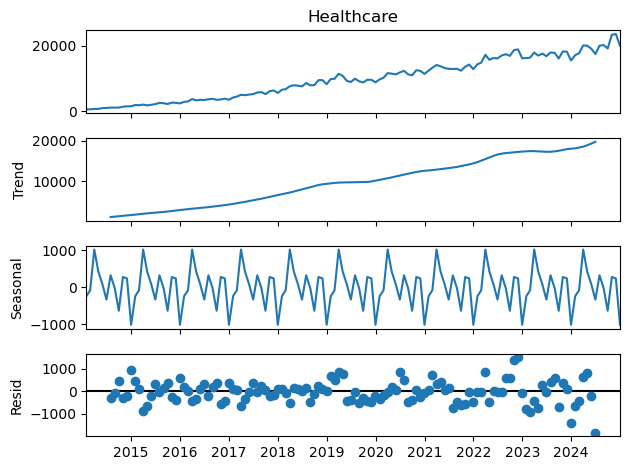

In [34]:
additive = seasonal_decompose(analysis_df, model="additive")
additive.plot()
plt.show()

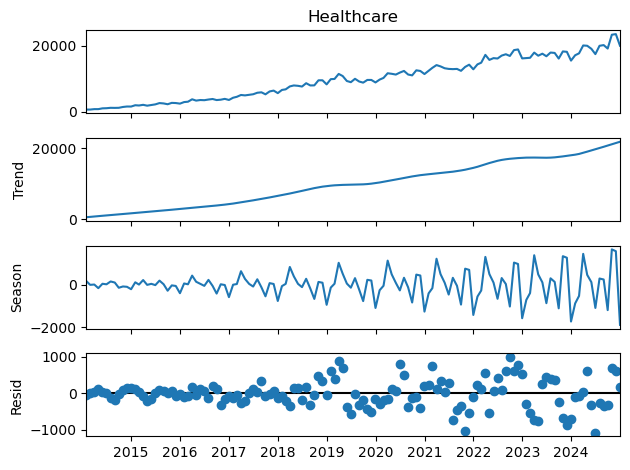

In [37]:
# STL Decomposition with correct seasonal value
stl = STL(analysis_df, seasonal=11) 
res = stl.fit()

# Plotting the decomposition
fig = res.plot()
plt.show()

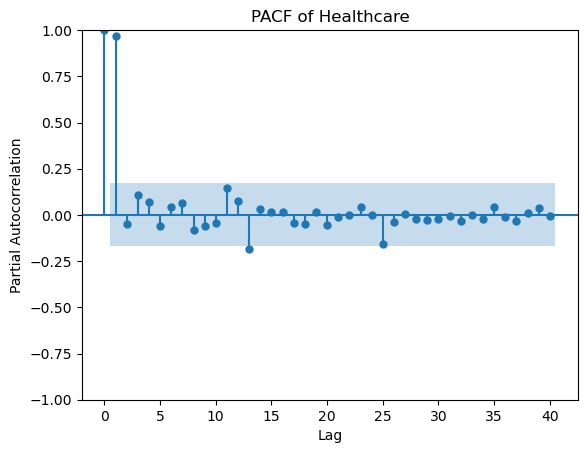

In [38]:
# Plotting the Partial Autocorrelation Function (PACF)
sgt.plot_pacf(analysis_df, lags=40)  
plt.title('PACF of Healthcare')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

## Observations

- Strong Upward Trend: The dominant feature of the data is a significant upward trend, indicating a consistent increase in healthcare calls over time.
- Identifiable Seasonality: There is a discernible seasonal pattern, though it is relatively weak compared to the trend.
- Good Model Fit: The residuals appear to be random, suggesting that the STL decomposition has captured the major patterns in the data well.
- No strong seasonal component.
- Process appears to be AR(1).

# Apply differencing 

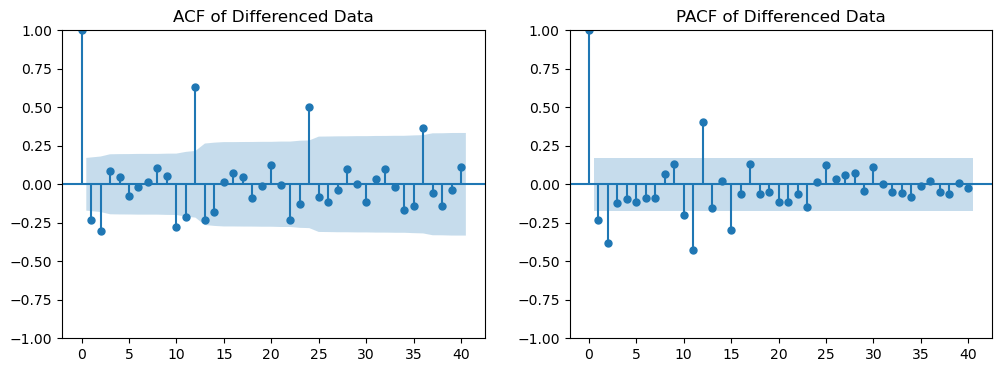

In [42]:
# First-Order Differencing
calls_diff = analysis_df.diff().dropna()  
# Plot ACF and PACF of the Differenced Data
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sgt.plot_acf(calls_diff, lags=40, ax=axes[0])
sgt.plot_pacf(calls_diff, lags=40, ax=axes[1])
axes[0].set_title('ACF of Differenced Data')
axes[1].set_title('PACF of Differenced Data')
plt.show()

In [44]:
adf_result = adfuller_test(calls_diff)
print("ADF Test Result:", adf_result)

kpss_result = kpss_test(calls_diff)
print("KPSS Test Result:", kpss_result)

ADF Test Result: {'Test Statistic': -3.444150447464889, 'P-Value': 0.009542765330356678, 'Critical Values': {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}, 'Interpretation': 'The series is likely stationary.'}
KPSS Test Result: {'Test Statistic': 0.20572323102060855, 'P-Value': 0.1, 'Critical Values': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, 'Interpretation': 'The series is likely stationary.'}


## Observations

- Data stationary after first-order differencing.
- Interpretation

Stationarity: The ACF and PACF plots suggest that the first-order differencing has made the data stationary. The autocorrelations quickly fall within the confidence interval.   

MA(1) or AR(1):

ACF: The significant spike at lag 1 in the ACF suggests a potential Moving Average (MA) component of order 1 (MA(1)).   

PACF: The significant spike at lag 2 in the PACF suggests a potential Autoregressive (AR) component of order 1 (AR(1)).

Combined ARMA(1,1): Since both ACF and PACF show a significant spike at lag 1, it's possible that an ARMA(1,1) model might be appropriate.

Weak Seasonality? The potential spike at lag 12 in the ACF is weak and might be due to chance. It's not strongly evident in the PACF.  We may want to investigate this further, we could consider adding a seasonal component to our model (e.g., SARIMA), but it's not a strong indication.